In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import animation
import torch
import json
import skimage.io as skio
from IPython.display import Video
import os
import re
from IPython.display import HTML

In [2]:
# Overcooked observations, in order
OBS = ['player_0_loc', 'player_1_loc', 'player_0_orientation_0', 'player_0_orientation_1', 'player_0_orientation_2', 'player_0_orientation_3', 'player_1_orientation_0', 'player_1_orientation_1', 'player_1_orientation_2', 'player_1_orientation_3', 'pot_loc', 'counter_loc', 'onion_disp_loc', 'tomato_disp_loc', 'dish_disp_loc', 'serve_loc', 'onions_in_pot', 'tomatoes_in_pot', 'onions_in_soup', 'tomatoes_in_soup', 'soup_cook_time_remaining', 'soup_done', 'dishes', 'onions', 'tomatoes', 'urgency']
ONEHOT_OBS_DIMS = [1]*16 + [3]*4 + [20] + [1]*5 # At each index, the dimensionality of the corresponding one-hot encoded observation 
assert len(OBS) == 26

In [712]:
# logdir = "data/logs/cross_play/SMIRL_PPO/coordination_ring_nook_adversarial/2023-10-19_10-23-57/"
# logdir = "data/logs/cross_play/PPO_SMIRL/coordination_ring_nook_adversarial/2023-10-18_19-08-57/"
# logdir = "data/logs/cross_play/SMIRL_PPO/coordination_ring_nook_adversarial/2023-11-08_22-37-52/"
# logdir = "data/logs/cross_play/PPO_SMIRL/coordination_ring_noblock/2023-11-08_21-56-51/"
# logdir = "data/logs/cross_play/SMIRL_PPO/coordination_ring_nook_adversarial/2023-11-08_22-37-52/"
# logdir = "data/logs/cross_play/PPO_SMIRL/coordination_ring/2023-11-08_22-39-14/"

# After fix
# logdir = "data/logs/cross_play/PPO_SMIRL/coordination_ring_nook_adversarial/2023-11-12_10-25-34/"
# logdir = "data/logs/cross_play/PPO_SMIRL/coordination_ring_noblock/2023-11-12_10-39-01/"
# logdir = "data/logs/cross_play/SMIRL_E_PPO/coordination_ring_nook_adversarial/2023-11-12_10-43-18/"
# logdir = "data/logs/cross_play/SMIRL_PPO/coordination_ring_nook_adversarial/2023-11-12_20-56-18/"
# logdir = "data/logs/cross_play/SMIRL_E_PPO/coordination_ring_nook_adversarial/2023-11-12_10-43-18/"

# After break
# logdir = "data/logs/cross_play/PPO_SMIRL/coordination_ring_noblock/2023-11-13_09-05-51/"
# logdir = "data/logs/cross_play/PPO_SMIRL/coordination_ring_nook_adversarial/2023-11-13_09-05-44/"
# logdir = "data/logs/cross_play/SMIRL_PPO/coordination_ring_noblock/no_anneal/2023-11-13_12-17-47/"
# logdir = "data/logs/cross_play/PPO_SMIRL/coordination_ring_nook_adversarial/no_anneal/2023-11-13_12-12-50/"

# New Empowerment!
# logdir = "data/logs/cross_play/PPO_SMIRL_E/coordination_ring_noblock/2023-12-05_10-27-39/"
# logdir = "data/logs/cross_play/PPO_SMIRL_E/coordination_ring_nook/2023-12-05_10-26-55/"
# logdir = "data/logs/cross_play/PPO_SMIRL_E/coordination_ring_nook/2023-12-05_15-38-50/"
# logdir = "data/logs/cross_play/PPO_SMIRL_E/coordination_ring_nook/2023-12-05_15-39-18/"

# TUBA
# logdir = "data/logs/cross_play/PPO_SMIRL_E/coordination_ring_nook/2023-12-13_14-35-42/"
# logdir = "data/logs/cross_play/PPO_SMIRL_E/coordination_ring_nook/2023-12-13_14-35-39/"
# logdir = "data/logs/cross_play/SMIRL_E_PPO/coordination_ring_nook/2023-12-13_14-41-02/"
# logdir = "data/logs/cross_play/SMIRL_E_PPO/coordination_ring_nook/no_anneal/2023-12-14_11-52-27/"
# logdir = "data/logs/cross_play/PPO_SMIRL_E/coordination_ring_nook/no_anneal/2023-12-15_09-42-25/"
# logdir = "data/logs/cross_play/SMIRL_E_SMIRL_E/coordination_ring_nook/2023-12-16_09-51-34/"
# logdir = "data/logs/cross_play/SMIRL_E_PPO/coordination_ring_nook/2023-12-18_19-41-46/"
# logdir = "data/logs/cross_play/SMIRL_E_PPO/coordination_ring_nook_adversarial/2023-12-18_22-05-51/"
# logdir = "data/logs/cross_play/SMIRL_E_PPO/coordination_ring_nook_adversarial/2023-12-19_07-05-51/" # Empowerment weight = 0.05
# logdir = "data/logs/cross_play/SMIRL_E_PPO/coordination_ring_nook_adversarial/2023-12-19_13-03-15/" # Empowerment weight = 1
# logdir = "data/logs/cross_play/PPO_SMIRL_E/coordination_ring_nook_adversarial/2023-12-19_13-03-23/" # Empowerment weight = 0.1
# logdir = "data/logs/cross_play/PPO_SMIRL_E/coordination_ring_nook_adversarial/no_anneal/2023-12-20_07-42-14/" # Empowerment weight = 1
# logdir = "data/logs/cross_play/PPO_SMIRL_E/coordination_ring_nook_adversarial/no_anneal/2023-12-20_07-42-11/" # Empowerment weight = 0.1
# logdir = "data/logs/cross_play/PPO_SMIRL_E/coordination_ring_nook_adversarial/no_anneal/2023-12-24_08-15-18/" # Empowerment weight = 0.01
# logdir = "data/logs/cross_play/SMIRL_E_PPO/coordination_ring_nook_adversarial/no_anneal/2023-12-21_06-44-50/" # Empowerment weight = 0.001
# Double Checks PPO/PPO
# logdir = "data/logs/cross_play/PPO_PPO/coordination_ring_nook/2023-12-14_11-20-48/"
# logdir = "data/logs/cross_play/PPO_PPO/coordination_ring_nook/no_anneal/2023-12-14_11-52-31/"

# Sequential
# logdir = "data/logs/cross_play/PPO_SMIRL/coordination_ring_nook/no_anneal/2023-12-15_19-54-28/" # Train SMIRL with PPO held fixed
# logdir = "data/logs/cross_play/PPO_SMIRL/coordination_ring_nook/no_anneal/2023-12-15_20-24-23/" # Train PPO with SMIRL held fixed
# logdir = "data/logs/cross_play/SMIRL_PPO/coordination_ring_nook/no_anneal/2023-12-15_20-55-12/" # Train SMIRL with PPO held fixed
# logdir = "data/logs/cross_play/SMIRL_PPO/coordination_ring_nook/19_no_anneal/2023-12-16_20-41-12/"

# Yell
# logdir = "data/logs/cross_play/PPO_SMIRL/coordination_ring_nook_adversarial/no_anneal/2023-12-22_06-47-19/"
# logdir = "data/logs/cross_play/SMIRL_PPO/coordination_ring_nook_adversarial/2023-12-23_06-18-22/"

# Empowerment
# logdir = "data/logs/cross_play/CONTRASTIVE_E_PPO/coordination_ring_nook/2024-01-16_09-59-57/"
# logdir = "data/logs/cross_play/CONTRASTIVE_E_PPO/coordination_ring_nook/2024-01-13_08-38-25/"
# logdir = "data/logs/cross_play/CONTRASTIVE_E_PPO/coordination_ring_nook_adversarial/2024-01-13_08-38-37/"
# logdir = "data/logs/cross_play/CONTRASTIVE_E_PPO/coordination_ring_nook/notemp/2024-01-18_09-31-42/"
# logdir = "data/logs/cross_play/PPO_CONTRASTIVE_E/coordination_ring_nook/notemp_nonorm/2024-01-18_09-37-05/"

# Empowerment with Replay Buffer
# logdir = "data/logs/cross_play/CONTRASTIVE_E_PPO/coordination_ring_nook/notemp/2024-01-18_17-51-35/"
# logdir = "data/logs/cross_play/CONTRASTIVE_E_PPO/coordination_ring_nook/notemp_nonorm/2024-01-18_17-50-31/"
# logdir = "data/logs/cross_play/PPO_CONTRASTIVE_E/coordination_ring_nook/2024-01-18_17-53-25/" # GOOD RESULT?? No, broken
# logdir = "data/logs/cross_play/PPO_CONTRASTIVE_E/coordination_ring_nook/2024-01-19_11-23-38/" # GOOD RESULT!
# logdir = "data/logs/cross_play/PPO_CONTRASTIVE_E/coordination_ring_nook/2024-01-19_11-23-40/" # Replication of above
# logdir = "data/logs/cross_play/CONTRASTIVE_E_PPO/coordination_ring_nook/2024-01-19_11-23-42/" # Replication of above
# logdir = "data/logs/cross_play/CONTRASTIVE_E_PPO/coordination_ring/2024-01-19_11-23-43/"

# Empowerment with Replay Buffer Updated
# logdir = "data/logs/cross_play/CONTRASTIVE_E_PPO/coordination_ring_nook/2024-01-21_16-37-48/"
# logdir = "data/logs/cross_play/CONTRASTIVE_E_PPO/coordination_ring_nook/2024-01-21_16-38-30/"
# logdir = "data/logs/cross_play/CONTRASTIVE_E_PPO/coordination_ring_nook/2024-01-21_16-37-48/"
# logdir = "data/logs/cross_play/PPO_CONTRASTIVE_E/coordination_ring_nook/test_both_using_true_reward/2024-01-21_16-41-34/"

In [713]:
SEQUENTIAL = False

In [714]:
SUFFICIENT_STATISTIC_DIM = 53

In [715]:
def get_all_checkpoints(logdir):
    # List all checkpoint ids
    all_checkpoints = []
    files = os.listdir(logdir)
    for file in files:
        if re.match("checkpoint_*", file):
            
            all_checkpoints.append(int(file[len("checkpoint_"):]))
    all_checkpoints = sorted(all_checkpoints)

    return all_checkpoints

In [716]:
def get_data(logdir):
    file = open(logdir + "result.json", "r")
    data = []
    for line in file:
        data.append(json.loads(line))

    file.close()

    return [data]
         
def get_sequential_data(sequential_checkpoints):
    data = []
    for path in sequential_checkpoints:
        result_path = re.match(".*\/(?=checkpoint_)", path).group(0)        
        data.extend(get_data(result_path))

    return data

In [717]:
all_checkpoints = get_all_checkpoints(logdir)

if SEQUENTIAL:
    sequential_checkpoints = np.load(f"{logdir}checkpoint_{all_checkpoints[-1]:06}/checkpoint-{all_checkpoints[-1]}_sequential.npy")
    data = get_sequential_data(sequential_checkpoints)
else:
    data = get_data(logdir)

In [718]:
def get_smirl_reward_full(data):
    smirl_reward_full = []

    for d in data:
        smirl_reward_full.append([])
        for feat_index in range(SUFFICIENT_STATISTIC_DIM):
            cum_reward = []
            for i in range(len(d)):
                cum_reward.append(d[i]["custom_metrics"][f"smirl_{feat_index}_mean"])
            smirl_reward_full[-1].append(cum_reward)
    
    smirl_reward_full = np.array(smirl_reward_full)
    smirl_reward = np.mean(smirl_reward_full, axis=1)
    
    return smirl_reward

In [719]:
data[0][1]["custom_metrics"]["contrastive_empowerment_rewards_mean"]

-198.68452548980713

In [720]:
smirl_reward = get_smirl_reward_full(data)

In [721]:
def get_reward_means(data, smirl_reward_full):
    policies = list(data[0][0]["policy_reward_mean"].keys())
    
    reward_means = []
    for d, smirl_reward in zip(data, smirl_reward_full):
        reward_means.append({})
        for policy in policies:
            print(policy)
            if "smirl_e" in policy:
                empowerment_scalar = (d[0]["policy_reward_mean"][policy]-smirl_reward[0])/d[0]["custom_metrics"]["empowerment_reward_mean"]
                print("Empowerment Scalar", empowerment_scalar)

                reward_means[-1][policy] = {"total": [ep["policy_reward_mean"][policy] for ep in d],
                                        "smirl": smirl_reward,
                                        "empowerment": [empowerment_scalar*ep["custom_metrics"]["empowerment_reward_mean"] for ep in d]}
            elif "smirl" in policy:
                reward_means[-1][policy] = {"total": [ep["policy_reward_mean"][policy] for ep in d],
                                        "smirl": smirl_reward}
            elif "contrastive_e" in policy:
                reward_means[-1][policy] = {"dense": [ep["custom_metrics"]["contrastive_empowerment_rewards_mean"] for ep in d[1:]]}
            elif "ppo" in policy and "agent_1_dense_mean" in d[0]["custom_metrics"]:
                reward_means[-1][policy] = {"dense": [ep["custom_metrics"]["agent_1_dense_mean"]  for ep in d],
                                        "sparse": [ep["custom_metrics"]["agent_1_sparse_mean"] for ep in d]}
            else:
                reward_means[-1][policy] = {"total": [ep["policy_reward_mean"][policy] for ep in d]}
    return reward_means

In [722]:
reward_means = get_reward_means(data, smirl_reward)

ppo_0
contrastive_e_0


In [723]:
def plot_reward_means(reward_means):
    for policy in reward_means.keys():
        if type(reward_means[policy]) == dict:
            for reward_type, reward in reward_means[policy].items():
                plt.plot(reward, label=reward_type)
            plt.title(f"{policy} reward mean")
            plt.xlabel("Epoch")
            plt.ylabel("Reward Mean")
            plt.yscale("symlog")
            plt.legend()
            plt.show()
        else:
            plt.plot(reward_means[policy])
            plt.title(f"{policy} reward mean")
            plt.xlabel("Epoch")
            plt.ylabel("Reward Mean")
            plt.show()

In [724]:
def aggregate_reward_means(reward_means):
    assert len(reward_means) > 0
    
    aggregated = {k: {f: [] for f in reward_means[0][k].keys()} for k in reward_means[0].keys()}

    for rm in reward_means:
        for policy in rm.keys():
            for metric in rm[policy].keys():
                aggregated[policy][metric].extend(rm[policy][metric])
    return aggregated

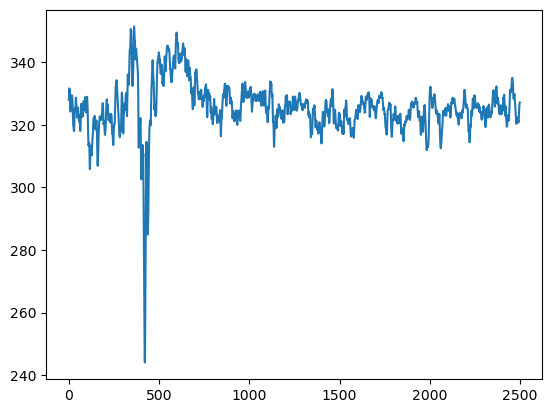

In [725]:
plt.plot(reward_means[0]["contrastive_e_0"]["dense"][500:])

In [726]:
aggregated_rms = aggregate_reward_means(reward_means)

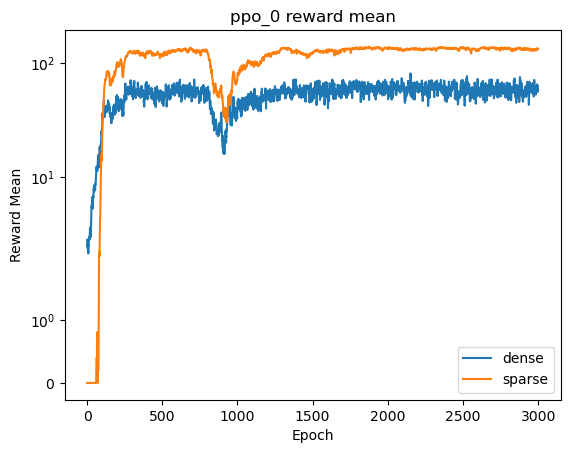

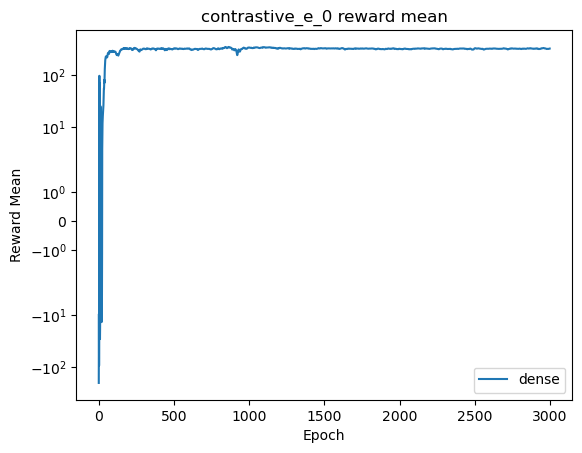

In [727]:
plot_reward_means(aggregated_rms)

Text(0.5, 1.0, 'Empowerment Classifier Loss')

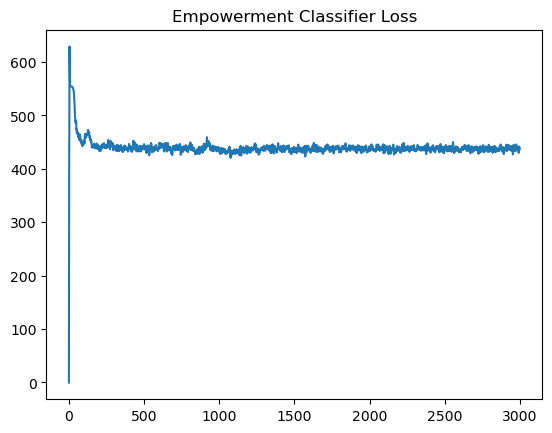

In [728]:
plt.plot([data[0][i]["custom_metrics"]["empowerment_classifier_loss_mean"] for i in range(len(data[0]))])
plt.title("Empowerment Classifier Loss")

In [706]:
# for policy in policies:
#     if type(reward_means[policy]) == dict:
#         for reward_type, reward in reward_means[policy].items():
#             plt.plot(reward, label=reward_type)
#         plt.title(f"{policy} reward mean")
#         plt.xlabel("Epoch")
#         plt.ylabel("Reward Mean")
#         plt.legend()
#         plt.show()
#     else:
#         plt.plot(reward_means[policy])
#         plt.title(f"{policy} reward mean")
#         plt.xlabel("Epoch")
#         plt.ylabel("Reward Mean")
#         plt.show()

In [707]:
# cmap = plt.cm.get_cmap("rainbow", 26)
# colors = []
# for i in range(26):
#     for k in range(ONEHOT_OBS_DIMS[i]):
#         colors.append(cmap(i))

In [510]:
# ax = plt.subplot(111)

# ax.bar(x=np.arange(len(smirl_reward)), height=smirl_reward, color=colors)
# plt.title("SMIRL Reward Deconstructed")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Reward")

# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 1.5, box.height])

# # Custom legend
# handles = [mpatches.Patch(color=cmap(i), label=OBS[i]) for i in range(26)]
# plt.legend(handles=handles, ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))

In [511]:
# fig, ax = plt.subplots()
# barcollection = ax.bar(x=np.arange(SUFFICIENT_STATISTIC_DIM), height=smirl_reward_full[:, 0], color=colors)
# plt.title("SMIRL Reward Deconstructed")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Reward")

# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 1, box.height])

# # Custom legend
# handles = [mpatches.Patch(color=cmap(i), label=OBS[i]) for i in range(26)]
# # plt.legend(handles=handles, ncol=2, loc='center right', bbox_to_anchor=(1, 0.5))

# n = smirl_reward_full.shape[1]

# def animate(i):
#     y = smirl_reward_full[:, i]
#     for i, b in enumerate(barcollection):
#         b.set_height(y[i])
        
# anim = animation.FuncAnimation(fig, animate, repeat=False, blit=False, frames=np.arange(0, n, n//20))
# HTML(anim.to_jshtml())

In [512]:
ONEHOT_OBS_DIMS

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 20, 1, 1, 1, 1, 1]

In [513]:
# contrib_by_feature = []
# for i in range(26):
#     contrib_by_feature.append(0)
#     for k in range(ONEHOT_OBS_DIMS[i]):
#         contrib_by_feature[-1] += smirl_reward[i + k]/SUFFICIENT_STATISTIC_DIM

# assert len(contrib_by_feature) == 26

In [514]:
# def get_contrib_by_feature(i):
#     # Gets contrib_by_feature for epoch i
#     rewards = smirl_reward_full[:, i]
    
#     contrib_by_feature = []
#     for i in range(26):
#         contrib_by_feature.append(0)
#         for k in range(ONEHOT_OBS_DIMS[i]):
#             contrib_by_feature[-1] += rewards[i + k]/53
    
#     assert len(contrib_by_feature) == 26
#     return contrib_by_feature

In [515]:
# ax = plt.subplot(111)

# ax.bar(x=np.arange(26), height=contrib_by_feature, color=[cmap(i) for i in range(26)])
# plt.title("SMIRL Reward Contributions by Feature")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Reward")

# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 1.5, box.height])

# # Custom legend
# handles = [mpatches.Patch(color=cmap(i), label=OBS[i]) for i in range(26)]
# plt.legend(handles=handles, ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))

In [516]:
# fig, ax = plt.subplots()
# barcollection = ax.bar(x=np.arange(26), height=contrib_by_feature, color=[cmap(i) for i in range(26)])
# plt.title("SMIRL Reward Contributions by Feature")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Reward")

# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 1, box.height])

# # Custom legend
# handles = [mpatches.Patch(color=cmap(i), label=OBS[i]) for i in range(26)]
# # plt.legend(handles=handles, ncol=2, loc='center right', bbox_to_anchor=(1, 0.5))

# n = smirl_reward_full.shape[1]

# def animate(i):
#     y = get_contrib_by_feature(i)
#     for i, b in enumerate(barcollection):
#         b.set_height(y[i])
        
# anim = animation.FuncAnimation(fig, animate, repeat=False, blit=False, frames=np.arange(0, n, n//20))
# HTML(anim.to_jshtml())

In [517]:
# for policy in policies:
#     if type(reward_means[policy]) == dict:
#         for reward_type, reward in reward_means[policy].items():
#             plt.plot(reward, label=reward_type)
#         plt.title(f"{policy} reward mean")
#         plt.xlabel("Epoch")
#         plt.ylabel("Reward Mean")
#         plt.legend()
#         plt.show()
#     else:
#         plt.plot(reward_means[policy])
#         plt.title(f"{policy} reward mean")
#         plt.xlabel("Epoch")
#         plt.ylabel("Reward Mean")
#         plt.show()

In [484]:
# empowerment_scalar

In [485]:
# probability_of_correct_detection = []
# beta = 1/100

# for i in range(len(data)):
#     batch_probs = []

#     cm = data[i]["custom_metrics"]
#     for j in range(128):
#         prob = np.exp(cm[f"tc_{j}_mean"]*beta)/(np.exp(cm[f"nc_{j}_mean"]*beta) + np.exp(cm[f"tc_{j}_mean"]*beta))
#         batch_probs.append(prob)
        
#     probability_of_correct_detection.append(np.mean(batch_probs))
#     data[-1]["custom_metrics"]

In [486]:
# plt.plot(empowerment_classifier_loss)
# plt.ylabel("Loss")
# plt.xlabel("Epoch")
# plt.title("Empowerment Classifier Loss")

In [487]:
# plt.plot(probability_of_correct_detection)
# plt.title("Empowerment Probability of Correct Classification")
# plt.ylabel("Probability")
# plt.xlabel("Epoch")

In [488]:
sequential_checkpoints

NameError: name 'sequential_checkpoints' is not defined

In [729]:
# List all video checkpoints
video_checkpoints = []

for id in all_checkpoints:
    files = os.listdir(logdir + f"checkpoint_{id:06}")
    has_video = False
    for file in files:
        if re.match(".*\.mp4", file):
            has_video = True
            break
    if has_video:
        video_checkpoints.append(id)

In [730]:
video_checkpoints

[3000]

In [585]:
checkpoint_path = sequential_checkpoints[-3]
Video(url=checkpoint_path + "_0.mp4")

NameError: name 'sequential_checkpoints' is not defined

In [731]:
checkpoint_id = video_checkpoints[-1]
checkpoint_path = f"checkpoint_{checkpoint_id:06}/checkpoint-{checkpoint_id}"
Video(url=logdir + checkpoint_path + "_1.mp4")

In [39]:
checkpoint_path

'checkpoint_003000/checkpoint-3000'

In [356]:
for policy in policies:
    im = skio.imread(logdir + checkpoint_path + f"_policy_{policy}_action_probs.png")
    skio.imshow(im)
    plt.show()

NameError: name 'policies' is not defined